In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:

!unzip new_set.zip

Archive:  new_set.zip
   creating: new_set/test_data/
   creating: new_set/test_data/1/
  inflating: new_set/test_data/1/User.1.16.jpg  
  inflating: new_set/test_data/1/User.1.27.jpg  
 extracting: new_set/test_data/1/User.1.30.jpg  
 extracting: new_set/test_data/1/User.1.45.jpg  
 extracting: new_set/test_data/1/User.1.46.jpg  
 extracting: new_set/test_data/1/User.1.47.jpg  
   creating: new_set/test_data/2/
 extracting: new_set/test_data/2/test_2.jpg  
 extracting: new_set/test_data/2/User.2.58.jpg  
 extracting: new_set/test_data/2/User.2.63.jpg  
 extracting: new_set/test_data/2/User.2.67.jpg  
 extracting: new_set/test_data/2/User.2.71.jpg  
 extracting: new_set/test_data/2/User.2.77.jpg  
 extracting: new_set/test_data/2/User.2.78.jpg  
 extracting: new_set/test_data/2/User.2.83.jpg  
 extracting: new_set/test_data/2/User.2.84.jpg  
 extracting: new_set/test_data/2/User.2.98.jpg  
   creating: new_set/test_data/3/
 extracting: new_set/test_data/3/User.3.38.jpg  
 extracting: n

In [3]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.5 MB/s eta 0:00:00


In [4]:
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [6]:
class_names = ['1','2','3' , '4']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

input_shape = (90, 90,3)

In [7]:
def load_data():
  datasets = ['new_set/train_data/' , 'new_set/test_data/']
  output = []

  for dataset in datasets:

    images = []
    labels = []
    print("Loading{}".format(dataset))

    for folder in os.listdir(dataset):
      label= class_names_label[folder]

      for file in tqdm(os.listdir(os.path.join(dataset,folder))):
        image_path = os.path.join(os.path.join(dataset, folder), file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, input_shape[:2]) 

        images.append(image)
        labels.append(label)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    output.append((images, labels))
  return output





In [8]:
(x_train, y_train), (x_test, y_test) = load_data()

Loadingnew_set/train_data/


100%|██████████| 92/92 [00:00<00:00, 1155.31it/s]


Loadingnew_set/test_data/


100%|██████████| 9/9 [00:00<00:00, 3317.40it/s]


In [9]:
n_train = x_train.shape[0]
n_test = y_test.shape[0]


print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(input_shape))

Number of training examples: 352
Number of testing examples: 39
Each image is of size: (90, 90, 3)


In [ ]:
#  Configure the hyperparameters


In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 24  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [11]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (352, 90, 90, 3) - y_train shape: (352,)
x_test shape: (39, 90, 90, 3) - y_test shape: (39,)


In [12]:
# Use data augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [14]:
# Implement multilayer perceptron (MLP)

In [15]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [16]:
#Implement patch creation as a layer

In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [18]:
#lets display

Image size: 72 X 72
Patch size: 24 X 24
Patches per image: 9
Elements per patch: 1728


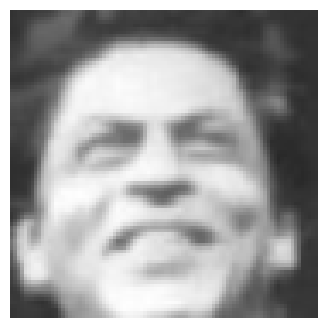

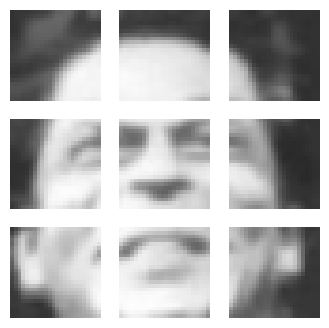

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [20]:
#Implement the patch encoding layer

In [21]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [22]:
#Build the ViT model

In [23]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [24]:
#Compile, train, and evaluate the mode

In [25]:
num_classes = 4

In [26]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
2/2 [==============================] - 34s 3s/step - loss: 1.8250 - accuracy: 0.3259 - top-5-accuracy: 1.0000 - val_loss: 3.5508 - val_accuracy: 0.0000e+00 - val_top-5-accuracy: 1.0000
Epoch 2/100
2/2 [==============================] - 3s 1s/step - loss: 1.8411 - accuracy: 0.5443 - top-5-accuracy: 1.0000 - val_loss: 0.8704 - val_accuracy: 0.7500 - val_top-5-accuracy: 1.0000
Epoch 3/100
2/2 [==============================] - 2s 1s/step - loss: 1.5188 - accuracy: 0.5633 - top-5-accuracy: 1.0000 - val_loss: 0.7343 - val_accuracy: 0.8056 - val_top-5-accuracy: 1.0000
Epoch 4/100
2/2 [==============================] - 2s 718ms/step - loss: 0.8513 - accuracy: 0.7025 - top-5-accuracy: 1.0000 - val_loss: 0.9287 - val_accuracy: 0.5278 - val_top-5-accuracy: 1.0000
Epoch 5/100
2/2 [==============================] - 2s 400ms/step - loss: 0.8487 - accuracy: 0.6867 - top-5-accuracy: 1.0000 - val_loss: 0.6029 - val_accuracy: 0.7222 - val_top-5-accuracy: 1.0000
Epoch 6/100
2/2 [============